In [277]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#### Load from data_cleaned.csv 

In [477]:
df = pd.read_csv("data_cleaned.csv")
df = df.drop(columns=["Unnamed: 0"])
df = df.drop(columns="Unnamed: 0.1")

convert string to list

In [478]:
df["relevant_articles"] = df["relevant_articles"].apply(lambda x:eval(x))

convert imprisonment length from month to year 

In [479]:
df["imprisonment_year"] = df["imprisonment"].apply(lambda x: int(round(x/12)))

check df

In [480]:
df.head()

,accusation,defendants,fact,punish_of_money,relevant_articles,term_of_imprisonment,death_penalty,imprisonment,life_imprisonment,tokenized,cleaned_fact,fact_cleaned,imprisonment_year
0,['受贿'],['杨1某'],安阳县人民检察院指控：2009年至2012年，被告人杨1某利用其在洛阳市中级人民法院工作，先...,0,"[383, 388, 383, 386]","{'death_penalty': False, 'imprisonment': 126, ...",False,126,False,"['安阳县', '人民检察院', '指控', '：', '2009', '年', '至', ...","['安阳县', '人民检察院', '指控', '年', '年', '被告人', '杨', '...","['安阳县', '人民检察院', '指控', '：', '2009', '年', '至', ...",10
1,"['[组织、强迫、引诱、容留、介绍]卖淫', '[引诱、容留、介绍]卖淫']",['马某某'],大同市新荣区人民检察院指控：从2013年4月起，被告人马某某在新荣区新荣村村委会南自租的平房...,0,[359],"{'death_penalty': False, 'imprisonment': 7, 'l...",False,7,False,"['大同市', '新荣区', '人民检察院', '指控', '：', '从', '2013'...","['大同市', '新荣区', '人民检察院', '指控', '年', '月', '被告人',...","['大同市', '新荣区', '人民检察院', '指控', '：', '从', '2013'...",1
2,"['非法[持有、私藏][枪支、弹药]', '[走私、贩卖、运输、制造]毒品']",['王某'],公诉机关指控，自2010年开始，被告人王某从“傻波”（在逃，另案处理）处购买甲基苯丙胺（冰毒...,3000,[347],"{'death_penalty': False, 'imprisonment': 10, '...",False,10,False,"['公诉', '机关', '指控', '，', '自', '2010', '年', '开始'...","['公诉', '机关', '指控', '年', '被告人', '王某', '傻波', '逃'...","['公诉', '机关', '指控', '，', '自', '2010', '年', '开始'...",1
3,"['[走私、贩卖、运输、制造]毒品', '容留他人吸毒']",['李1某'],晋中市榆次区人民检察院指控：一、2016年2月11日，被告人李1某在晋中东高速口附近贩卖给申...,12000,"[347, 347, 354]","{'death_penalty': False, 'imprisonment': 102, ...",False,102,False,"['晋中市', '榆次区', '人民检察院', '指控', '：', '一', '、', '...","['晋中市', '榆次区', '人民检察院', '指控', '年', '月', '日', '...","['晋中市', '榆次区', '人民检察院', '指控', '：', '一', '、', '...",8
4,['非法经营'],['彭某'],广西壮族自治区田东县人民检察院指控，2012年10月22日，被告人彭某为获利，在明知运输的物...,30000,[225],"{'death_penalty': False, 'imprisonment': 36, '...",False,36,False,"['广西壮族自治区', '田东县', '人民检察院', '指控', '，', '2012',...","['广西壮族自治区', '田东县', '人民检察院', '指控', '年', '月', '日...","['广西壮族自治区', '田东县', '人民检察院', '指控', '，', '2012',...",3


In [351]:
df.shape

(150000, 11)

### Exclude cases involving death penalty and life imprisonment

In [352]:
df = df[df["death_penalty"]==False][df["life_imprisonment"]==False]

In [353]:
df = df.drop(columns=["death_penalty", "life_imprisonment"])
df = df.drop(columns="fact_cleaned")

check df again

In [354]:
df.shape

(148381, 9)

In [355]:
df.head()

,accusation,defendants,fact,punish_of_money,relevant_articles,term_of_imprisonment,imprisonment,tokenized,imprisonment_year
0,['受贿'],['杨1某'],安阳县人民检察院指控：2009年至2012年，被告人杨1某利用其在洛阳市中级人民法院工作，先...,0,"[383, 388, 383, 386]","{'death_penalty': False, 'imprisonment': 126, ...",126,"['安阳县', '人民检察院', '指控', '：', '2009', '年', '至', ...",10
1,"['[组织、强迫、引诱、容留、介绍]卖淫', '[引诱、容留、介绍]卖淫']",['马某某'],大同市新荣区人民检察院指控：从2013年4月起，被告人马某某在新荣区新荣村村委会南自租的平房...,0,[359],"{'death_penalty': False, 'imprisonment': 7, 'l...",7,"['大同市', '新荣区', '人民检察院', '指控', '：', '从', '2013'...",1
2,"['非法[持有、私藏][枪支、弹药]', '[走私、贩卖、运输、制造]毒品']",['王某'],公诉机关指控，自2010年开始，被告人王某从“傻波”（在逃，另案处理）处购买甲基苯丙胺（冰毒...,3000,[347],"{'death_penalty': False, 'imprisonment': 10, '...",10,"['公诉', '机关', '指控', '，', '自', '2010', '年', '开始'...",1
3,"['[走私、贩卖、运输、制造]毒品', '容留他人吸毒']",['李1某'],晋中市榆次区人民检察院指控：一、2016年2月11日，被告人李1某在晋中东高速口附近贩卖给申...,12000,"[347, 347, 354]","{'death_penalty': False, 'imprisonment': 102, ...",102,"['晋中市', '榆次区', '人民检察院', '指控', '：', '一', '、', '...",8
4,['非法经营'],['彭某'],广西壮族自治区田东县人民检察院指控，2012年10月22日，被告人彭某为获利，在明知运输的物...,30000,[225],"{'death_penalty': False, 'imprisonment': 36, '...",36,"['广西壮族自治区', '田东县', '人民检察院', '指控', '，', '2012',...",3


### Summary of df

In [345]:
df["imprisonment_year"].describe()

count    148381.000000
mean          2.177496
std           2.846578
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          25.000000
Name: imprisonment_year, dtype: float64

In [356]:
df["punish_of_money"].describe()

count    1.483810e+05
mean     2.515467e+04
std      1.487599e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.000000e+03
max      5.500000e+08
Name: punish_of_money, dtype: float64

In [357]:
df["accusation"].value_counts()

['[走私、贩卖、运输、制造]毒品']                                                                   4055
['抢劫', '盗窃']                                                                          2666
['盗窃']                                                                                2208
['非法占用农用地']                                                                           1935
['[生产、销售]不符合安全标准的食品']                                                                 1875
['[生产、销售]假药']                                                                         1874
['非法种植毒品原植物']                                                                         1872
['重大责任事故']                                                                            1866
['失火']                                                                                1864
['污染环境']                                                                              1863
['非法行医']                                                                              1859

In [491]:
df["cleaned_fact"]

0         ['安阳县', '人民检察院', '指控', '年', '年', '被告人', '杨', '...
1         ['大同市', '新荣区', '人民检察院', '指控', '年', '月', '被告人',...
2         ['公诉', '机关', '指控', '年', '被告人', '王某', '傻波', '逃'...
3         ['晋中市', '榆次区', '人民检察院', '指控', '年', '月', '日', '...
4         ['广西壮族自治区', '田东县', '人民检察院', '指控', '年', '月', '日...
5         ['审理', '查明', '×', '×', '犯罪事实', '年', '月', '日', ...
6         ['长沙市', '城区', '人民检察院', '指控', '年', '年', '期间', '...
7         ['公诉', '机关', '指控', '被告人', '李某', '挂靠', '浙江', '中...
8         ['审理', '查明', '年', '月', '日', '时许', '被告人', '李', ...
9         ['洮南市', '人民检察院', '指控', '年', '月', '月', '期间', '被...
10        ['审理', '查明', '年', '月', '被告人', '王某', '寻求', '刺激'...
11        ['鄯善县', '人民检察院', '指控', '年', '月', '祁', '另案处理', ...
12        ['公诉', '机关', '指控', '年', '月', '年', '月', '期间', '...
13        ['二审', '审理', '查明', '事实', '证据', '原审', '判决', '认定...
14        ['审理', '查明', '被告人', '梁某', '年', '被害人', '朱某', '甲...
15        ['绥化市', '北林区', '人民检察院', '起诉', '指控', '年', '月', ...
16        ['公诉', '机关', '指控', '被告人', '蒋',

### Feature Engineering

##### Find words that appear most frequently

Compare uncleand tokenized words and cleaned tokenized words, notice that cleaned version does make more sense.

In [359]:
tokenized_high_freq = pd.Series([y for x in df["tokenized"].values.flatten() for y in x.split()]).value_counts()

In [360]:
tokenized_high_freq[200:250]

'物品',       25362
'说明',       25335
'单位',       25197
'材料',       24996
'工作',       24899
'贷款',       24654
'周某',       24517
'黄',        24089
'吴',        23733
'出具',       23627
'30',       23615
'方式',       23372
'信息',       23245
'银行',       23172
'15',       23154
'职务',       22895
'工程',       22868
'赵某',       22806
'吴某',       22760
'用',        22719
'又',        22440
'认定',       22309
'发生',       22306
'用于',       22136
'造成',       21785
'检查',       21675
'收受',       21638
'骗取',       21605
'2010',     21422
'资金',       21267
'一天',       21179
'家中',       21171
'当庭',       21064
'以下',       21039
'多次',       20908
'当场',       20801
'决定书',      20544
'合同',       20530
'徐某',       20305
'附近',       20215
'先后',       20075
'其中',       19881
'投案',       19873
'14',       19620
'办理',       19490
'16',       19374
'甲基苯丙胺',    19347
'2017',     19335
'二',        19027
'应',        18997
dtype: int64

In [492]:
cleaned_tokenized_high_freq = pd.Series([y for x in df["cleaned_fact"].values.flatten() for y in x.split()]).value_counts()

In [493]:
cleaned_tokenized_high_freq

'×',          852914
'被告人',        728029
'年',          478946
'月',          413476
'日',          270428
'元',          259292
'指控',         160010
'被害人',        144189
'人民币',        140795
'机关',         132668
'证据',         132271
'公司',         110345
'罪',          109242
'供述',         105416
'甲',          102402
'公诉',         100395
'鉴定',          97650
'中',           96519
'张',           96426
'人民检察院',       93817
'李某',          84479
'行为',          84291
'证人',          83949
'证言',          83040
'规定',          82275
'有限公司',        81362
'中华人民共和国',     79247
'王',           78419
'刑法',          74209
'证明',          72999
               ...  
'利牧',              1
'从泓发',             1
'穷东',              1
'某与芦',             1
'足法',              1
'长着',              1
'路五直',             1
'某约易',             1
'震地',              1
'故武',              1
'超别',              1
'高帮鞋',             1
'榔树',              1
'痒',               1
'开帮后',             1
'冼要',              1
'某甲和明',      

**Visualization - how to choose word as feature**

**Function for word choice visualization**

In [361]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for text in texts:
        temp = []
        for word in words:
            if word in text:
                temp.append(1)
            else:
                temp.append(0)
        indicator_array.append(temp)
    return indicator_array

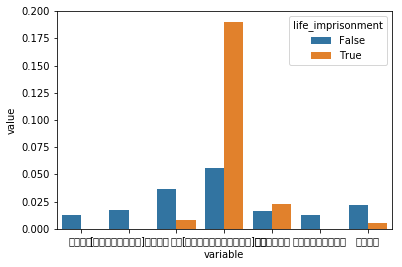

In [319]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
indicator_words = ['玩忽职守', '[制造、贩卖、传播]淫秽物品', '受贿','[走私、贩卖、运输、制造]毒品', '容留他人吸毒', '非法种植毒品原植物', '寻衅滋事']
graph_temp = pd.DataFrame(words_in_texts(indicator_words, train['accusation']), columns=indicator_words)
graph_temp['life_imprisonment'] = train['life_imprisonment']
sns.barplot(x="variable", y="value", data=graph_temp.melt('life_imprisonment'), hue="life_imprisonment", ci=None)

Final version of indicator words

In [1]:
indicator_words = ["刑事责任", "非法", "扣押", "销售", "追究其", '犯罪事实', '足以认定', '毒品', '户籍', '利用', '触犯', '开庭审理','公诉', '辩解','经营',  '信息', '银行', '工程', '骗取', '职务']

### train test split

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
Y_train = train['imprisonment_year']
Y_test = test['imprisonment_year']

**Function for generating feature matrix**

In [ ]:
def feature_gen(words, data, column):
    # return feature matrix 
    temp = words_in_texts(words, data[column])
    features_matrix = pd.DataFrame(temp, columns=words)  
    return features_matrix

### Baseline model: all predict the mean 

In [369]:
Y_train_predict = np.full((len(train),), train["imprisonment_year"].mean())

training_mse = mean_squared_error(Y_train_predict, Y_train)
training_rmse = np.sqrt(training_mse)
print("Training RMSE: ", training_rmse)

Training RMSE:  2.8394035525564587


In [370]:
Y_test_predict = np.full((len(test),), test["imprisonment_year"].mean())

test_mse = mean_squared_error(Y_test_predict, Y_test)
test_rmse = np.sqrt(test_mse)
print("test RMSE: ", test_rmse)

test RMSE:  2.8750484099650415


Text(0.5, 1.0, 'Baseline Model - imprisonment_year predict vs actual')

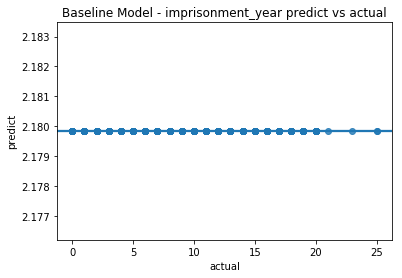

In [371]:
sns.regplot(Y_test, Y_test_predict)
plt.xlabel("actual")
plt.ylabel("predict")
plt.title("Baseline Model - imprisonment_year predict vs actual")

## Modeling

### Trained on indicator words

In [372]:
indicator_words = ["刑事责任", "非法", "扣押", "销售", "追究其", '犯罪事实', '足以认定', '毒品', '户籍', '利用', '触犯', '开庭审理','公诉', '辩解','经营',  '信息', '银行', '工程', '骗取', '职务']

Generate train feature matrix

In [373]:
features_words_train = feature_gen(indicator_words, train, "tokenized")

In [374]:
features_words_train.shape

(118704, 20)

Generate test feature matrix 

In [375]:
features_words_test = feature_gen(indicator_words, test, "tokenized")

In [376]:
features_words_test.shape

(29677, 20)

**Train accuracy**

In [377]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
train=train.reset_index(drop=True)
Y_train = train["imprisonment_year"]
model.fit(features_words_train, Y_train)
Y_train_predict = model.predict(features_words_train)

training_mse = mean_squared_error(Y_train_predict, Y_train)
training_rmse = np.sqrt(training_mse)
print("Training RMSE: ", training_rmse)

Training RMSE:  2.7237550965901605


**Test accuracy**

In [378]:
test = test.reset_index(drop=True)
Y_test = test["imprisonment_year"]
Y_test_predict = model.predict(features_words_test)

test_mse = mean_squared_error(Y_test_predict, Y_test)
test_rmse = np.sqrt(test_mse)
print("test RMSE: ", test_rmse)

test RMSE:  2.765686560209878


### Trained on accusations

**Find non-repetitive accusations**

In [379]:
accusations = train["accusation"].apply(lambda x: eval(x)).tolist()
accusations = [item for sublist in accusations for item in sublist]

Total number of accusations appeared: 147513

In [428]:
len(accusations)

147513

In [425]:
from collections import Counter
# check 50 most frequent accusations
Counter(accusations).most_common(50)

[('盗窃', 7696),
 ('[走私、贩卖、运输、制造]毒品', 6734),
 ('故意伤害', 4837),
 ('抢劫', 3814),
 ('诈骗', 2709),
 ('受贿', 2691),
 ('寻衅滋事', 2583),
 ('危险驾驶', 2089),
 ('[制造、贩卖、传播]淫秽物品', 2018),
 ('交通肇事', 2007),
 ('容留他人吸毒', 1997),
 ('[组织、强迫、引诱、容留、介绍]卖淫', 1994),
 ('贪污', 1874),
 ('非法[持有、私藏][枪支、弹药]', 1793),
 ('开设赌场', 1782),
 ('职务侵占', 1690),
 ('[伪造、变造、买卖]国家机关[公文、证件、印章]', 1682),
 ('强奸', 1674),
 ('非法持有毒品', 1672),
 ('信用卡诈骗', 1662),
 ('敲诈勒索', 1658),
 ('[掩饰、隐瞒][犯罪所得、犯罪所得收益]', 1658),
 ('抢夺', 1654),
 ('妨害公务', 1614),
 ('赌博', 1612),
 ('非法吸收公众存款', 1612),
 ('非法占用农用地', 1611),
 ('非法经营', 1608),
 ('故意毁坏财物', 1608),
 ('非法拘禁', 1605),
 ('合同诈骗', 1603),
 ('[窝藏、包庇]', 1590),
 ('挪用资金', 1588),
 ('滥伐林木', 1580),
 ('行贿', 1573),
 ('挪用公款', 1556),
 ('过失致人死亡', 1556),
 ('拒不执行[判决、裁定]', 1552),
 ('假冒注册商标', 1550),
 ('[虚开增值税专用发票、用于骗取出口退税、抵扣税款发票]', 1549),
 ('盗伐林木', 1534),
 ('[生产、销售]假药', 1529),
 ('放火', 1528),
 ('污染环境', 1521),
 ('[生产、销售]不符合安全标准的食品', 1519),
 ('[引诱、容留、介绍]卖淫', 1512),
 ('伪造[公司、企业、事业单位、人民团体]印章', 1508),
 ('重大责任事故', 1506),
 ('[制作、复制、出版、贩卖、传播]淫秽物品牟利

Get a list of non-rep accusations

In [382]:
non_rep = []
for a in accusations:
    if a not in non_rep:
        non_rep.append(a)

Total number of accusations if each type counted once: 202

In [383]:
len(non_rep)

202

Generate train matrix

In [384]:
accusation_features = feature_gen(non_rep, train, "accusation")

In [385]:
accusation_features.shape

(118704, 202)

Generate test matrix

In [386]:
accusation_features_test = feature_gen(non_rep, test, "accusation")

In [387]:
accusation_features_test.shape

(29677, 202)

**Training Accuracy**

In [388]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
train=train.reset_index(drop=True)
Y_train = train["imprisonment_year"]
model.fit(accusation_features, Y_train)
Y_train_predict = model.predict(accusation_features)

training_mse = mean_squared_error(Y_train_predict, Y_train)
training_rmse = np.sqrt(training_mse)
print("Training RMSE: ", training_rmse)

Training RMSE:  2.2019326424855046


**Test Accuracy**

In [389]:
test = test.reset_index(drop=True)
Y_test = test["imprisonment_year"]
Y_test_predict = model.predict(accusation_features_test)

test_mse = mean_squared_error(Y_test_predict, Y_test)
test_rmse = np.sqrt(test_mse)
print("test RMSE: ", test_rmse)

test RMSE:  2.2269617261359373


## Trained on both accusations and indicator_words

Generate train matrix by merging accusation feature matrix and indicator_words feature matrix

In [390]:
features_combined = pd.concat([accusation_features, features_words_train], axis=1)

In [391]:
features_combined.shape

(118704, 222)

Generate trest matrix by merging accusation feature matrix and indicator_words feature matrix

In [392]:
features_combined_test = pd.concat([accusation_features_test, features_words_test], axis=1)

In [393]:
features_combined_test.shape

(29677, 222)

**Train accuracy**

In [394]:
model = LinearRegression(normalize=True)
train=train.reset_index(drop=True)
Y_train = train["imprisonment_year"]
model.fit(features_combined, Y_train)
Y_train_predict = model.predict(features_combined)

training_mse = mean_squared_error(Y_train_predict, Y_train)
training_rmse = np.sqrt(training_mse)
print("Training RMSE: ", training_rmse)

Training RMSE:  2.1837983804533203


**Test accuracy**

In [395]:
test = test.reset_index(drop=True)
Y_test = test["imprisonment_year"]
Y_test_predict = model.predict(features_combined_test)

test_rmse = np.sqrt(test_mse)
print("test RMSE: ", test_rmse)

test RMSE:  2.2269617261359373


### Visualization for prediction

Text(0.5, 1.0, 'imprisonment_year predict vs actual')

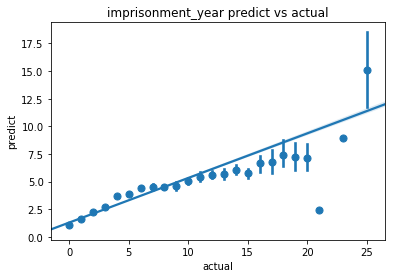

In [396]:
sns.regplot(Y_test, Y_test_predict,x_estimator=np.mean)
plt.xlabel("actual")
plt.ylabel("predict")
plt.title("imprisonment_year predict vs actual")

### Add feature - relevant article

In [ ]:
relevant_articles = train["relevant_articles"].to_list()

In [398]:
len(relevant_articles)

172752

Find non-rep relevant articles 

In [450]:
non_rep_articles = []
for a in relevant_articles:
    if a not in non_rep_articles:
        non_rep_articles.append(int(a))

In [400]:
len(non_rep_articles)

183

Find 50 most frequent articles

In [462]:
freq_50_articles = [int(key) for key, _ in Counter(relevant_articles).most_common(50)]

Generate train feature matrix for freq_50_articles

In [463]:
articles_features_50 = feature_gen(freq_50_articles, train, "relevant_articles")

In [464]:
articles_features_50.shape

(118704, 50)

Generate test feature matrix for freq_50_articles

In [465]:
articles_features_test = feature_gen(freq_50_articles, test, "relevant_articles")

In [466]:
articles_features_test.shape

(29677, 50)

Combine train feature matrixs for indicator words, accusations, relevant articles

In [467]:
features_combined_a = pd.concat([articles_features_50, features_combined], axis =1)

In [459]:
features_combined_a.shape

(118704, 272)

Combine test feature matrixs for indicator words, accusations, relevant articles

In [468]:
features_combined_a_test = pd.concat([articles_features_test, features_combined_test], axis =1)

In [469]:
features_combined_a_test.shape

(29677, 272)

### Train accuracy

In [470]:
model = LinearRegression()
Y_train = train["imprisonment_year"]
model.fit(features_combined_a, Y_train)
Y_train_predict = model.predict(features_combined_a)

training_mse = mean_squared_error(Y_train_predict, Y_train)
training_rmse = np.sqrt(training_mse)
print("Training RMSE: ", training_rmse)

Training RMSE:  2.1372150803513223


## Test accuracy

In [471]:
Y_test = test["imprisonment_year"]
Y_test_predict = model.predict(features_combined_a_test)

test_mse = mean_squared_error(Y_test_predict, Y_test)
test_rmse = np.sqrt(test_mse)
print("test RMSE: ", test_rmse)

test RMSE:  2.1787758284722063


Prediction Visualizatin

Text(0.5, 1.0, 'imprisonment_year predict vs actual')

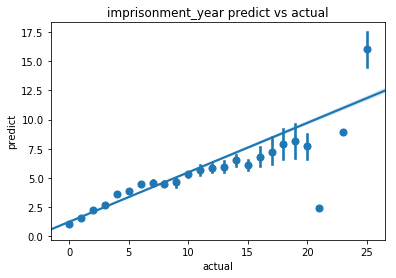

In [472]:
sns.regplot(Y_test, Y_test_predict,x_estimator=np.mean)
plt.xlabel("actual")
plt.ylabel("predict")
plt.title("imprisonment_year predict vs actual")